<a href="https://colab.research.google.com/github/dev-aram/KDT_TASK/blob/master/AI_%ED%97%88%EB%B8%8C_%EB%8D%B0%EC%9D%B4%ED%84%B0_%ED%95%9C%EA%B5%AD%EC%96%B4_NPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  데이터셋 선정 - 감성 대화 말뭉치
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=data&dataSetSn=86

# 필요한 라이브러리 임포트

In [ ]:
import pandas as pd
import numpy  as  np
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model
import gensim

# 데이터프레임 제작  및  데이터 전처리

In [ ]:
file = '/content/drive/MyDrive/KDT 시즌2/9. 자연어 처리/과제/data/감성대화말뭉치(최종데이터)_Training.xlsx'

df = pd.read_excel(file)

In [ ]:
# 결측값 제거
df = df.dropna()

In [ ]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42694 entries, 304 to 51629
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  42694 non-null  int64 
 1   연령          42694 non-null  object
 2   성별          42694 non-null  object
 3   상황키워드       42694 non-null  object
 4   신체질환        42694 non-null  object
 5   감정_대분류      42694 non-null  object
 6   감정_소분류      42694 non-null  object
 7   사람문장1       42694 non-null  object
 8   시스템문장1      42694 non-null  object
 9   사람문장2       42694 non-null  object
 10  시스템문장2      42694 non-null  object
 11  사람문장3       42694 non-null  object
 12  시스템문장3      42694 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.6+ MB


,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
304,305,중년,여성,"재정,은퇴,노후준비",해당없음,상처,상처,지금까지 힘들게 일했는데 은퇴해서 돈이 없다고 하니 자식이 화를 내서 상처를 받았어.,돈이 없다고 하니 자식이 화를 내서 상처를 받으셨군요.,너무 화가 나. 도와줬던 건 기억 못 하고 더 받을 생각만 하니.,자식들이 받을 생각만 해서 화가 나셨군요. 이 기분을 바꿀 만한 일이 있을까요?,앞으로는 자식보다 나를 생각하며 살아야겠어. 자식 위해 살아도 필요 없다는 말 이제...,이제는 자식보다 나를 생각하며 살려 하시는군요.
305,306,중년,여성,"재정,은퇴,노후준비",해당없음,상처,상처,친구한테 은퇴할 거라고 얘기했더니 앞으로 뭘 먹고 살 거냐면서 비웃더라고. 기분이 ...,비웃는 친구의 말에 기분이 나쁘셨군요.,아주 나쁜 친구야. 은퇴를 내가 하고 싶어 하는 것도 아닌데 말이야.,은퇴를 비웃는 친구가 나쁘다고 생각하시는군요. 앞으로 어떻게 하실 생각이신가요?,은퇴 후 조금 쉬며 즐기려고 해. 내가 잘할 수 있는 일이 분명 있을 테니까.,은퇴 후에는 쉬면서 즐기려고 할 생각이시군요.
306,307,중년,여성,"재정,은퇴,노후준비",해당없음,상처,상처,친구한테 은퇴한다고 했더니 그게 말이나 되는 거냐며 날 한심한 사람 취급해서 서운했어.,친구분이 은퇴를 한심하게 취급해서 서운하셨군요.,맞아. 그동안 내가 얼마나 힘들게 일했는지 알고 있으면서 그런 말을 하다니.,얼마나 힘들었는지 아는 친구분이 그런 말을 했군요. 기분이 나아질 만한 방법이 있을까요?,감정을 추스르고 나중에 연락을 해야겠어. 지금은 많이 서운해.,감정을 추스르고 나중에 연락을 할 생각이시군요.
307,308,중년,여성,"재정,은퇴,노후준비",해당없음,상처,상처,그동안 열심히 달려와서 좀 쉬려고 하는데 은퇴한다고 하니 주변에서 다 말려서 기분이...,그동안 너무 고생하셨어요. 주변 분들이 많이 걱정해 주시나 봐요.,응. 그렇지만 내 결정에 다들 냉담하게 반응하니 기분이 좋지 않아.,다들 냉담하게 반응해 기분이 좋지 않으시군요. 이 기분을 어떻게 바꿔 볼 수 있을까요?,일단 여행을 다녀 보려고. 그동안 너무 앞만 보고 달려왔어.,여행을 다녀 볼 생각이시군요.
308,309,중년,여성,"재정,은퇴,노후준비",해당없음,상처,상처,많은 고민 후 은퇴를 결심했는데 주변에서 다들 섣부른 생각이라고 해서 마음이 안 좋아.,은퇴를 결심했는데 주변에선 섣부르다고 해서 마음이 안 좋으셨군요.,힘들게 결심했는데 다들 반대하니까 조금 더 고민해 보는 게 좋을까 싶어.,조금 더 고민하는 게 좋을지 생각하시는군요. 어떤 선택을 해야 좋을까요?,한 달 정도 더 고민을 해 보려고. 지금 너무 마음이 지쳤어.,마음이 지쳐 한 달 정도 더 고민해 볼 생각이시군요.


In [ ]:
#  0   Unnamed: 0  42694 non-null  int64
#  1   연령          42694 non-null  object
#  2   성별          42694 non-null  object
#  3   상황키워드       42694 non-null  object
#  4   신체질환        42694 non-null  object
#  5   감정_대분류      42694 non-null  object
#  6   감정_소분류      42694 non-null  object
#  7   사람문장1       42694 non-null  object
#  8   시스템문장1      42694 non-null  object
#  9   사람문장2       42694 non-null  object
#  10  시스템문장2      42694 non-null  object
#  11  사람문장3       42694 non-null  object
#  12  시스템문장3      42694 non-null  object

df.drop(['Unnamed: 0', '연령','성별', '상황키워드', '신체질환', '감정_대분류',
              '감정_소분류','사람문장2','사람문장3', '시스템문장1', '시스템문장2', '시스템문장3'], axis=1, inplace=True)

<ipython-input-75-c48048adef2a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Unnamed: 0', '연령','성별', '상황키워드', '신체질환', '감정_대분류',


In [ ]:
df

,사람문장1
304,지금까지 힘들게 일했는데 은퇴해서 돈이 없다고 하니 자식이 화를 내서 상처를 받았어.
305,친구한테 은퇴할 거라고 얘기했더니 앞으로 뭘 먹고 살 거냐면서 비웃더라고. 기분이 ...
306,친구한테 은퇴한다고 했더니 그게 말이나 되는 거냐며 날 한심한 사람 취급해서 서운했어.
307,그동안 열심히 달려와서 좀 쉬려고 하는데 은퇴한다고 하니 주변에서 다 말려서 기분이...
308,많은 고민 후 은퇴를 결심했는데 주변에서 다들 섣부른 생각이라고 해서 마음이 안 좋아.
...,...
51625,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.
51626,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.
51627,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.
51628,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.


In [ ]:
# 중복된 데이터를  제거
df = df.drop_duplicates(subset='사람문장1').reset_index(drop=True)
print(len(df))

42670


In [ ]:
# 데이터셋의 특수 문자 제거
df['사람문장1'] = df['사람문장1'].str.replace('[^가-힣]', ' ')

<ipython-input-78-9a15227c67bc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['사람문장1'] = df['사람문장1'].str.replace('[^가-힣]', ' ')


In [ ]:
# 데어터셋의 길이가 너무 짧은 단어 제거(단어 길이가 1이하)
df['사람문장1'] = df['사람문장1'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
df

,사람문장1
0,지금까지 힘들게 일했는데 은퇴해서 돈이 없다고 하니 자식이 화를 내서 상처를 받았어
1,친구한테 은퇴할 거라고 얘기했더니 앞으로 먹고 거냐면서 비웃더라고 기분이 나빴어
2,친구한테 은퇴한다고 했더니 그게 말이나 되는 거냐며 한심한 사람 취급해서 서운했어
3,그동안 열심히 달려와서 쉬려고 하는데 은퇴한다고 하니 주변에서 말려서 기분이 좋지 않아
4,많은 고민 은퇴를 결심했는데 주변에서 다들 섣부른 생각이라고 해서 마음이 좋아
...,...
42665,나이가 먹고 이제 돈도 벌어 오니까 어떻게 살아가야 할지 막막해 능력도 없고
42666,몸이 많이 약해졌나 이제 전과 같이 일하지 못할 같아 너무 짜증
42667,이제 어떻게 해야 할지 모르겠어 남편도 그렇고 노후 준비도 되어서 미래가 걱정돼
42668,몇십 년을 함께 살았던 남편과 이혼했어 그동안의 세월에 배신감을 느끼고 너무 화가


# 불용어 제거

In [ ]:
stopword = ['얻지','범한','즈음','가지','자주','이제','붙이','도하','일로','거나','로부터','날로','이내','다운','내지','로서','로써']
df['사람문장1'] = df['사람문장1'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopword]))

df['사람문장1']

0          지금까지 힘들게 일했는데 은퇴해서 돈이 없다고 하니 자식이 화를 내서 상처를 받았어
1            친구한테 은퇴할 거라고 얘기했더니 앞으로 먹고 거냐면서 비웃더라고 기분이 나빴어
2           친구한테 은퇴한다고 했더니 그게 말이나 되는 거냐며 한심한 사람 취급해서 서운했어
3        그동안 열심히 달려와서 쉬려고 하는데 은퇴한다고 하니 주변에서 말려서 기분이 좋지 않아
4             많은 고민 은퇴를 결심했는데 주변에서 다들 섣부른 생각이라고 해서 마음이 좋아
                               ...                       
42665             나이가 먹고 돈도 벌어 오니까 어떻게 살아가야 할지 막막해 능력도 없고
42666                    몸이 많이 약해졌나 전과 같이 일하지 못할 같아 너무 짜증
42667           어떻게 해야 할지 모르겠어 남편도 그렇고 노후 준비도 되어서 미래가 걱정돼
42668       몇십 년을 함께 살았던 남편과 이혼했어 그동안의 세월에 배신감을 느끼고 너무 화가
42669          남편과 결혼한 사십 년이야 사람 만나는 것도 버겁고 알던 사람도 점점 사라져
Name: 사람문장1, Length: 42670, dtype: object

# 토큰화

In [ ]:
tokenized_doc = df['사람문장1'].apply(lambda x: x.split())
tokenized_doc

0        [지금까지, 힘들게, 일했는데, 은퇴해서, 돈이, 없다고, 하니, 자식이, 화를, ...
1        [친구한테, 은퇴할, 거라고, 얘기했더니, 앞으로, 먹고, 거냐면서, 비웃더라고, ...
2        [친구한테, 은퇴한다고, 했더니, 그게, 말이나, 되는, 거냐며, 한심한, 사람, ...
3        [그동안, 열심히, 달려와서, 쉬려고, 하는데, 은퇴한다고, 하니, 주변에서, 말려...
4        [많은, 고민, 은퇴를, 결심했는데, 주변에서, 다들, 섣부른, 생각이라고, 해서,...
                               ...                        
42665    [나이가, 먹고, 돈도, 벌어, 오니까, 어떻게, 살아가야, 할지, 막막해, 능력도...
42666          [몸이, 많이, 약해졌나, 전과, 같이, 일하지, 못할, 같아, 너무, 짜증]
42667    [어떻게, 해야, 할지, 모르겠어, 남편도, 그렇고, 노후, 준비도, 되어서, 미래...
42668    [몇십, 년을, 함께, 살았던, 남편과, 이혼했어, 그동안의, 세월에, 배신감을, ...
42669    [남편과, 결혼한, 사십, 년이야, 사람, 만나는, 것도, 버겁고, 알던, 사람도,...
Name: 사람문장1, Length: 42670, dtype: object

In [ ]:
tokenized_doc =  tokenized_doc.to_list()
len(tokenized_doc)

42670

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

In [ ]:
word2idx = tokenizer.word_index
idx2word =  {value:key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [ ]:
vocab_size = len(word2idx)
print(f'단어 사전의 크기: {vocab_size}')

단어 사전의 크기: 48110


In [ ]:
print(encoded[0])

[462, 598, 1744, 7185, 54, 346, 241, 693, 209, 795, 537, 89]


# Skip-gram

In [ ]:
training_dataset = [skipgrams(sample, vocabulary_size=vocab_size,  window_size=10) for sample in encoded[:100]]
print(f'전체 샘플 수 :{len(skip_gram)}')

전체 샘플 수 :100


In [ ]:
pairs, labels = skip_gram[0][0], skip_gram[0][1]
print(f'3 pairs{pairs[:3]}')
print(f'3 pairs{labels[:3]}')

3 pairs[[795, 18853], [693, 46471], [241, 346]]
3 pairs[0, 0, 1]


In [ ]:
print(len(pairs))
print(len(labels))

260
260


In [ ]:
for i in range(5):
    print('{:s}({:d}, {:s} {:d}) -> {:d}'.format(
        idx2word[pairs[i][0]], pairs[i][0],
        idx2word[pairs[i][1]], pairs[i][1],
        labels[i]
    ))

내서(795, 주더라고 18853) -> 0
자식이(693, 유언을 46471) -> 0
하니(241, 없다고 346) -> 1
자식이(693, 페이퍼를 31871) -> 0
지금까지(462, 늙으신 8131) -> 0


# 단어 임베딩 모델 구현

In [ ]:
embedding_dim = 100

w_inputs = Input(shape=(1,), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

c_inputs = Input(shape=(1,), dtype='int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

In [ ]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,),  input_shape=(1,1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam')

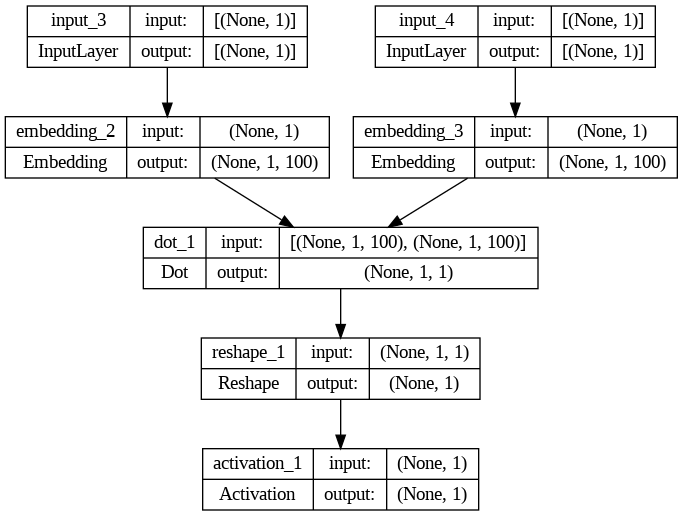

In [ ]:
plot_model(model, to_file='file.png', show_shapes=True, show_layer_names=True)

In [ ]:
for epoch in range(100):
    loss=0
    for _,  elem in enumerate(training_dataset):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)
    print('Epoch:', epoch+1, 'Loss', loss)

Epoch: 1 Loss 69.31167310476303
Epoch: 2 Loss 68.49591612815857
Epoch: 3 Loss 66.97906082868576
Epoch: 4 Loss 64.08150601387024
Epoch: 5 Loss 59.506905019283295
Epoch: 6 Loss 53.519439935684204
Epoch: 7 Loss 46.73660483956337
Epoch: 8 Loss 39.809666216373444
Epoch: 9 Loss 33.24896486103535
Epoch: 10 Loss 27.382252097129822
Epoch: 11 Loss 22.364541471004486
Epoch: 12 Loss 18.21302806586027
Epoch: 13 Loss 14.85524045675993
Epoch: 14 Loss 12.175488516688347
Epoch: 15 Loss 10.049023389816284
Epoch: 16 Loss 8.361482545733452
Epoch: 17 Loss 7.016802720725536
Epoch: 18 Loss 5.93823959864676
Epoch: 19 Loss 5.066187495365739
Epoch: 20 Loss 4.355013048276305
Epoch: 21 Loss 3.769970666617155
Epoch: 22 Loss 3.284596398472786
Epoch: 23 Loss 2.8786535654217005
Epoch: 24 Loss 2.536568947136402
Epoch: 25 Loss 2.246265411376953
Epoch: 26 Loss 1.9982980387285352
Epoch: 27 Loss 1.7852160427719355
Epoch: 28 Loss 1.6010911762714386
Epoch: 29 Loss 1.4411674994044006
Epoch: 30 Loss 1.3015994057059288
Epoch: 

# 단어간 유사도 측정

In [ ]:
f = open('vectors.txt', 'w')
f.write('{} {}\n'.format(vocab_size, embedding_dim))
vectors = model.get_weights()[0]
print(vectors)
print(len(vectors))

for word ,i in tokenizer.word_index.items():
    f.write('{} {} \n'.format(word, ' '.join(map(str, list(vectors[i-1, :])))))
f.close()

[[ 0.02239331 -0.02784895 -0.03776829 ...  0.02062914  0.0046667
  -0.04062472]
 [ 0.78402597  0.6952576  -0.7245043  ...  0.41474164  0.78237695
   0.6567591 ]
 [ 0.35348555 -0.37669575 -0.8449763  ...  0.5941341  -0.7113219
   0.76445466]
 ...
 [ 0.01300542  0.03037458 -0.03929489 ... -0.00562041  0.03490807
   0.02061843]
 [-0.02133011  0.02281726 -0.00458536 ... -0.00362532 -0.0278774
  -0.00534822]
 [ 0.00084813  0.01450985  0.04476381 ... -0.01189276  0.03368572
   0.02314443]]
48110


In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['유언을'])

[('끝자락에서', 0.42031756043434143),
 ('지내라고', 0.41153448820114136),
 ('입힐까', 0.40539970993995667),
 ('나빠지고', 0.3810625970363617),
 ('기특해하셨어', 0.37270402908325195),
 ('해놓을걸', 0.3449993133544922),
 ('기사에게', 0.34453779458999634),
 ('체결에', 0.3435434401035309),
 ('윗몸일으키기도', 0.34120509028434753),
 ('진급하고', 0.3402619957923889)]

In [ ]:
w2v.most_similar(positive=['늙으신'])

[('스트레스에', 0.41146546602249146),
 ('오셨던', 0.41065138578414917),
 ('제빵', 0.3900495767593384),
 ('배움을', 0.3895462453365326),
 ('미련이', 0.3828847110271454),
 ('외식을', 0.3815886080265045),
 ('매력적이고', 0.3574623465538025),
 ('보내줬거든', 0.3535585105419159),
 ('강아지라고', 0.3496938943862915),
 ('교대에', 0.3486538529396057)]